## Feed backward model

This is the code for feedbackward model

- First the hidden state and input for the pyramidal neuron are generated
- Then the network is established using the brian2 module
    - For the neurons Neuron classes are used. The parameters for these classes are fitted by xenia sterl :REF HER PAPER
    - Two different synapses are added to network to connect the pyramidal and inhibitory cell.
- The information of the output spike train is determined
- An analyses is based on all the information

In [1]:
import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

In [2]:
from brian2 import *
from matplotlib import pyplot as plt
import Documentation.parameters as p
from Foundations.helpers import scale_input_theory, make_spiketrain
from Foundations.MI import analyze_exp
import pandas as pd

In [3]:
from Foundations.input import Input

In [4]:
from Old_testing.make_dynamic_experiment_ori import make_dynamic_experiments
from Old_testing.currentmodel import Barrel_PC, Barrel_IN

In [5]:
defaultclock = p.dt*ms
np.random.seed()
seed = np.random.randint(1000000000)

Import the Input current (Old code)
The following code computes the input theory and the hidden state via make_dynamic_experiment
The input theory is scaled to a usable input with scale_input_theory. This makes from the noisy signal a scaled and timed signal in ampere.

In [6]:
[input_theory, hidden_state] = make_dynamic_experiments(p.qon_qoff_type, p.baseline, p.tau, p.factor_ron_roff, p.mean_firing_rate, p.sampling_rate, p.duration)

inj_current = scale_input_theory(input_theory, 0, 17, p.dt)

[]

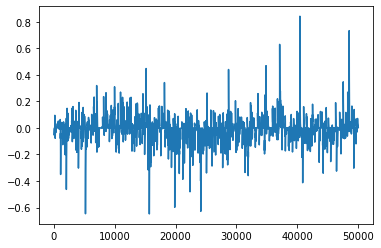

In [7]:
plt.plot(input_theory)
plt.plot()

In [8]:
start_scope()
PC = Barrel_PC(p.dt, inj_current)

PC_neuron = PC.getNeurongroup()

PC_M = StateMonitor(PC_neuron, 'v', record=True)
PC_S = SpikeMonitor(PC_neuron, 'v', record = True)

run(p.duration*ms)

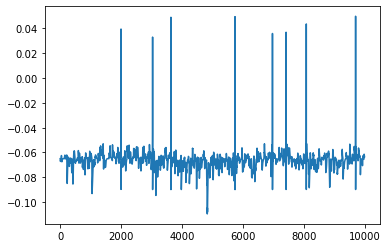

In [9]:
plot(PC_M.t / ms, PC_M.v[0], label='PC_pre')

# Making of the neurons
Here the neurons are made.
The Barrel_PC generates an excitatory neuron and the Barrel_IN an inhibitory neuron. The inhibitory neuron has no input and only gets input from the PC neuron.

In [10]:
start_scope()
#Initialising the neuron classes
PC = Barrel_PC(p.dt, inj_current)
IN = Barrel_IN(p.dt, None, Input=False)
#Getting the neurongroups
PC_neuron = PC.getNeurongroup()
IN_neuron = IN.getNeurongroup()

net = Network(PC_neuron, IN_neuron)

PC_M = StateMonitor(PC_neuron, 'v', record=True)
PC_S = SpikeMonitor(PC_neuron, 'v', record = True)
IN_M = StateMonitor(IN_neuron, 'v', record=True)

net.add(PC_M, IN_M, PC_S)

#getting all the parameters for in the synapse
syn = Synapses(PC_neuron, IN_neuron, on_pre='''v_post += 4.7*mV''', delay=0.6 * ms, dt=p.dt * ms)
syn.connect(i=0, j=0) #connects the first PC neuron to the interneuron

syn2 = Synapses(IN_neuron, PC_neuron, on_pre='''v_post -= 2*mV''', delay=0.6 * ms, dt=p.dt * ms)
syn2.connect(i=0, j=1) #connect the interneuren to the post synaptic PC
net.add(syn, syn2)

net.run(p.duration*ms)

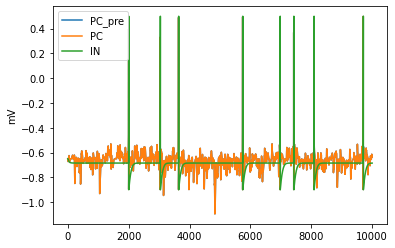

In [11]:
figure()
plot(PC_M.t / ms, PC_M.v[0]*10, label='PC_pre')
plot(PC_M.t / ms, PC_M.v[1]*10, label='PC')
plot(IN_M.t / ms, IN_M.v[0]*10, label="IN")
#plot(pre_PC_M.t/ms, pre_PC_M.v[0])
ylabel('mV')
legend()

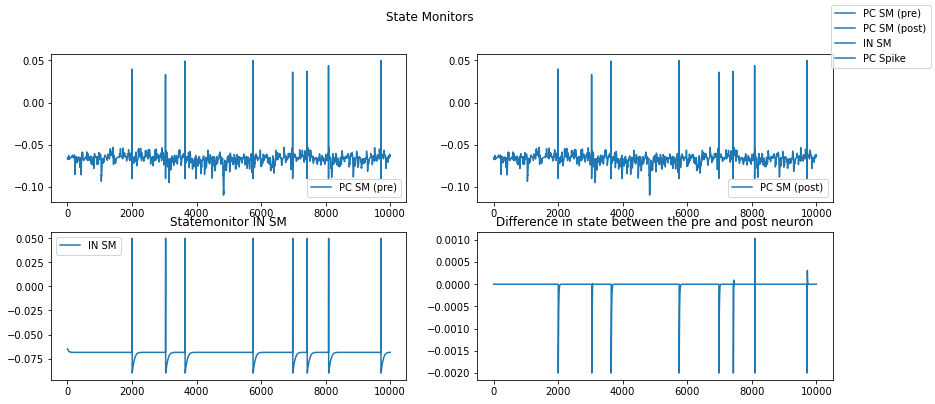

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(14,6))

axs[0, 0].plot(PC_M.t/ms, PC_M.v[0], label= 'PC SM (pre)')
axs[0,0].legend()
axs[0, 1].plot(PC_M.t/ms, PC_M.v[1], label= 'PC SM (post)')
axs[0,1].legend()

axs[1, 0].plot(IN_M.t/ms, IN_M.v[0], label= 'IN SM')
axs[1, 0].legend()
axs[1, 0].set_title('Statemonitor IN SM')

axs[1, 1].plot(PC_M.t/ms, PC_M.v[1] - PC_M.v[0], label= 'PC Spike')
axs[1, 1].set_title('Difference in state between the pre and post neuron')



fig.suptitle('State Monitors')
fig.legend()
plt.show()

In [13]:
## Estimating the best

# Estimating the Mutual information

In [14]:
spiketrain_PC = make_spiketrain(PC_S)

In [15]:
# output.replace(r'\\n', ' ', regex= True)

## Analyzing (PLZ WORK PLZ WORK)

In [53]:
start_scope()
#Initialising the neuron classes
PC = Barrel_PC(p.dt, inj_current)
IN = Barrel_IN(p.dt, None, Input=False) #the barrel neuron has no input
#Getting the neuron groups
PC_neuron = PC.getNeurongroup()
IN_neuron = IN.getNeurongroup()

net2 = Network(PC_neuron,
               IN_neuron)

PC_M = StateMonitor(PC_neuron, 'v', record=True)
PC_S = SpikeMonitor(PC_neuron, 'v', record = True)
IN_M = StateMonitor(IN_neuron, 'v', record=True)

net2.add(PC_M, IN_M, PC_S)
w1 = 0
w2 = 0
#getting all the parameters for in the synapse
syn = Synapses(PC_neuron, IN_neuron, on_pre='''v_post += 4.7*mV''', delay=0.6 * ms, dt=p.dt * ms)
syn.connect(i=0, j=0)

syn2 = Synapses(IN_neuron, PC_neuron, on_pre='''v_post += -w2*mV''', delay=0.7 * ms, dt=p.dt * ms)
syn2.connect(i=0, j=1)
net2.add(syn, syn2)

net2.store()
output = pd.DataFrame()
weights = np.arange(1,15)
samples = p.duration/p.dt

for w2 in weights:
    net2.restore()
    w2 = w2
    label = str(w1)
    net2.run(p.duration*ms)
    spiketrain = make_spiketrain(PC_S)
    output = pd.concat([output, analyze_exp(hidden_state, input_theory,0, spiketrain,samples, label)], axis = 0)

In [54]:
output.replace(r'\\n', ' ', regex= True)

,weigts,Hxx,Hxy,MI_i,xhat_i,MSE_i,MI,qon,qoff,xhatspikes,MSE,F,F_I
0,0,0.899309,0.649656,0.249653,"[0.3333333333333333, 0.3333333333333333, 0.333...",0.148373,-2.39823,0.001902,0.000292,"[0.3333333333333333, 0.2558086956821952, 0.191...",0.314907,0.277605,-9.606269
0,0,0.899309,0.649656,0.249653,"[0.3333333333333333, 0.3333333333333333, 0.333...",0.148373,-2.39823,0.001902,0.000292,"[0.3333333333333333, 0.2558086956821952, 0.191...",0.314907,0.277605,-9.606269
0,0,0.899309,0.649656,0.249653,"[0.3333333333333333, 0.3333333333333333, 0.333...",0.148373,-2.39823,0.001902,0.000292,"[0.3333333333333333, 0.2558086956821952, 0.191...",0.314907,0.277605,-9.606269
0,0,0.899309,0.649656,0.249653,"[0.3333333333333333, 0.3333333333333333, 0.333...",0.148373,-2.39823,0.001902,0.000292,"[0.3333333333333333, 0.2558086956821952, 0.191...",0.314907,0.277605,-9.606269
0,0,0.899309,0.649656,0.249653,"[0.3333333333333333, 0.3333333333333333, 0.333...",0.148373,-2.39823,0.001902,0.000292,"[0.3333333333333333, 0.2558086956821952, 0.191...",0.314907,0.277605,-9.606269
0,0,0.899309,0.649656,0.249653,"[0.3333333333333333, 0.3333333333333333, 0.333...",0.148373,-2.39823,0.001902,0.000292,"[0.3333333333333333, 0.2558086956821952, 0.191...",0.314907,0.277605,-9.606269
0,0,0.899309,0.649656,0.249653,"[0.3333333333333333, 0.3333333333333333, 0.333...",0.148373,-2.39823,0.001902,0.000292,"[0.3333333333333333, 0.2558086956821952, 0.191...",0.314907,0.277605,-9.606269
0,0,0.899309,0.649656,0.249653,"[0.3333333333333333, 0.3333333333333333, 0.333...",0.148373,-2.39823,0.001902,0.000292,"[0.3333333333333333, 0.2558086956821952, 0.191...",0.314907,0.277605,-9.606269
0,0,0.899309,0.649656,0.249653,"[0.3333333333333333, 0.3333333333333333, 0.333...",0.148373,-2.39823,0.001902,0.000292,"[0.3333333333333333, 0.2558086956821952, 0.191...",0.314907,0.277605,-9.606269
0,0,0.899309,0.649656,0.249653,"[0.3333333333333333, 0.3333333333333333, 0.333...",0.148373,-2.39823,0.001902,0.000292,"[0.3333333333333333, 0.2558086956821952, 0.191...",0.314907,0.277605,-9.606269


## Plotting the network

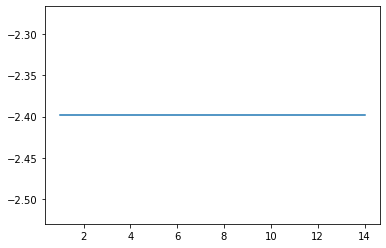

In [55]:
plt.figure()
plt.plot(weights, output['MI'])
plt.show()